# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [4]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [5]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
import tensorflow as tf

class QNetwork:
    def __init__(self, 
                 learning_rate=0.01, 
                 state_size=4, 
                 action_size=2, 
                 hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [8]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [10]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [11]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 7.0 Training loss: 1.2410 Explore P: 0.9993
Episode: 2 Total reward: 27.0 Training loss: 1.1605 Explore P: 0.9966
Episode: 3 Total reward: 9.0 Training loss: 1.1894 Explore P: 0.9958
Episode: 4 Total reward: 26.0 Training loss: 1.1266 Explore P: 0.9932
Episode: 5 Total reward: 9.0 Training loss: 1.1564 Explore P: 0.9923
Episode: 6 Total reward: 15.0 Training loss: 1.2599 Explore P: 0.9908
Episode: 7 Total reward: 15.0 Training loss: 1.1810 Explore P: 0.9894
Episode: 8 Total reward: 40.0 Training loss: 1.3489 Explore P: 0.9855
Episode: 9 Total reward: 16.0 Training loss: 1.2255 Explore P: 0.9839
Episode: 10 Total reward: 32.0 Training loss: 1.3670 Explore P: 0.9808
Episode: 11 Total reward: 18.0 Training loss: 1.2716 Explore P: 0.9790
Episode: 12 Total reward: 30.0 Training loss: 1.3966 Explore P: 0.9761
Episode: 13 Total reward: 16.0 Training loss: 1.4176 Explore P: 0.9746
Episode: 14 Total reward: 9.0 Training loss: 1.5132 Explore P: 0.9737
Episode: 15 Total r

Episode: 116 Total reward: 16.0 Training loss: 17.3196 Explore P: 0.8106
Episode: 117 Total reward: 15.0 Training loss: 165.2392 Explore P: 0.8094
Episode: 118 Total reward: 10.0 Training loss: 217.5583 Explore P: 0.8086
Episode: 119 Total reward: 29.0 Training loss: 20.5309 Explore P: 0.8062
Episode: 120 Total reward: 27.0 Training loss: 92.2815 Explore P: 0.8041
Episode: 121 Total reward: 20.0 Training loss: 151.8878 Explore P: 0.8025
Episode: 122 Total reward: 19.0 Training loss: 12.1043 Explore P: 0.8010
Episode: 123 Total reward: 18.0 Training loss: 78.7951 Explore P: 0.7996
Episode: 124 Total reward: 27.0 Training loss: 227.2028 Explore P: 0.7975
Episode: 125 Total reward: 16.0 Training loss: 92.7841 Explore P: 0.7962
Episode: 126 Total reward: 35.0 Training loss: 76.7857 Explore P: 0.7934
Episode: 127 Total reward: 14.0 Training loss: 222.2552 Explore P: 0.7924
Episode: 128 Total reward: 12.0 Training loss: 71.8739 Explore P: 0.7914
Episode: 129 Total reward: 24.0 Training loss:

Episode: 228 Total reward: 20.0 Training loss: 1.1571 Explore P: 0.6576
Episode: 229 Total reward: 11.0 Training loss: 1.4042 Explore P: 0.6568
Episode: 230 Total reward: 10.0 Training loss: 106.6835 Explore P: 0.6562
Episode: 231 Total reward: 11.0 Training loss: 72.8743 Explore P: 0.6555
Episode: 232 Total reward: 16.0 Training loss: 199.1070 Explore P: 0.6545
Episode: 233 Total reward: 26.0 Training loss: 2.5761 Explore P: 0.6528
Episode: 234 Total reward: 8.0 Training loss: 56.3979 Explore P: 0.6523
Episode: 235 Total reward: 13.0 Training loss: 56.8964 Explore P: 0.6514
Episode: 236 Total reward: 10.0 Training loss: 122.6433 Explore P: 0.6508
Episode: 237 Total reward: 11.0 Training loss: 71.7571 Explore P: 0.6501
Episode: 238 Total reward: 10.0 Training loss: 146.3111 Explore P: 0.6494
Episode: 239 Total reward: 10.0 Training loss: 1.7926 Explore P: 0.6488
Episode: 240 Total reward: 12.0 Training loss: 1.0416 Explore P: 0.6480
Episode: 241 Total reward: 9.0 Training loss: 52.4296

Episode: 342 Total reward: 18.0 Training loss: 0.9782 Explore P: 0.5644
Episode: 343 Total reward: 26.0 Training loss: 42.3544 Explore P: 0.5629
Episode: 344 Total reward: 13.0 Training loss: 13.6129 Explore P: 0.5622
Episode: 345 Total reward: 11.0 Training loss: 81.2144 Explore P: 0.5616
Episode: 346 Total reward: 7.0 Training loss: 90.6157 Explore P: 0.5612
Episode: 347 Total reward: 17.0 Training loss: 38.0204 Explore P: 0.5603
Episode: 348 Total reward: 9.0 Training loss: 30.5523 Explore P: 0.5598
Episode: 349 Total reward: 40.0 Training loss: 77.2698 Explore P: 0.5576
Episode: 350 Total reward: 26.0 Training loss: 21.5425 Explore P: 0.5562
Episode: 351 Total reward: 32.0 Training loss: 14.8343 Explore P: 0.5544
Episode: 352 Total reward: 8.0 Training loss: 13.7864 Explore P: 0.5540
Episode: 353 Total reward: 11.0 Training loss: 26.8809 Explore P: 0.5534
Episode: 354 Total reward: 9.0 Training loss: 1.2051 Explore P: 0.5529
Episode: 355 Total reward: 23.0 Training loss: 37.4133 Ex

Episode: 456 Total reward: 33.0 Training loss: 22.6622 Explore P: 0.3944
Episode: 457 Total reward: 35.0 Training loss: 21.2844 Explore P: 0.3931
Episode: 458 Total reward: 100.0 Training loss: 0.8245 Explore P: 0.3893
Episode: 459 Total reward: 24.0 Training loss: 9.9272 Explore P: 0.3883
Episode: 460 Total reward: 52.0 Training loss: 12.6375 Explore P: 0.3864
Episode: 461 Total reward: 26.0 Training loss: 26.1121 Explore P: 0.3854
Episode: 462 Total reward: 35.0 Training loss: 14.6824 Explore P: 0.3841
Episode: 463 Total reward: 31.0 Training loss: 26.2202 Explore P: 0.3829
Episode: 464 Total reward: 23.0 Training loss: 68.1734 Explore P: 0.3821
Episode: 465 Total reward: 33.0 Training loss: 1.4607 Explore P: 0.3809
Episode: 466 Total reward: 46.0 Training loss: 1.1091 Explore P: 0.3792
Episode: 467 Total reward: 29.0 Training loss: 2.1241 Explore P: 0.3781
Episode: 468 Total reward: 27.0 Training loss: 49.7501 Explore P: 0.3771
Episode: 469 Total reward: 43.0 Training loss: 1.4849 E

Episode: 569 Total reward: 33.0 Training loss: 1.1573 Explore P: 0.2173
Episode: 570 Total reward: 33.0 Training loss: 81.0160 Explore P: 0.2166
Episode: 571 Total reward: 31.0 Training loss: 1.4519 Explore P: 0.2159
Episode: 572 Total reward: 41.0 Training loss: 111.7910 Explore P: 0.2151
Episode: 573 Total reward: 65.0 Training loss: 99.5643 Explore P: 0.2138
Episode: 574 Total reward: 75.0 Training loss: 2.3873 Explore P: 0.2123
Episode: 575 Total reward: 22.0 Training loss: 2.3372 Explore P: 0.2118
Episode: 576 Total reward: 40.0 Training loss: 1.7618 Explore P: 0.2110
Episode: 577 Total reward: 29.0 Training loss: 80.7187 Explore P: 0.2104
Episode: 578 Total reward: 33.0 Training loss: 108.6433 Explore P: 0.2098
Episode: 579 Total reward: 24.0 Training loss: 82.4971 Explore P: 0.2093
Episode: 580 Total reward: 28.0 Training loss: 2.7331 Explore P: 0.2087
Episode: 581 Total reward: 22.0 Training loss: 1.5953 Explore P: 0.2083
Episode: 582 Total reward: 26.0 Training loss: 103.5604 

Episode: 689 Total reward: 33.0 Training loss: 0.8720 Explore P: 0.1004
Episode: 690 Total reward: 38.0 Training loss: 137.7136 Explore P: 0.1001
Episode: 691 Total reward: 28.0 Training loss: 0.8304 Explore P: 0.0998
Episode: 692 Total reward: 46.0 Training loss: 1.0258 Explore P: 0.0994
Episode: 693 Total reward: 40.0 Training loss: 2.2671 Explore P: 0.0990
Episode: 694 Total reward: 36.0 Training loss: 2.3930 Explore P: 0.0987
Episode: 695 Total reward: 31.0 Training loss: 1.4558 Explore P: 0.0984
Episode: 696 Total reward: 37.0 Training loss: 1.7293 Explore P: 0.0981
Episode: 697 Total reward: 30.0 Training loss: 1.4959 Explore P: 0.0979
Episode: 698 Total reward: 50.0 Training loss: 0.8838 Explore P: 0.0974
Episode: 699 Total reward: 38.0 Training loss: 157.8241 Explore P: 0.0971
Episode: 700 Total reward: 114.0 Training loss: 159.2189 Explore P: 0.0961
Episode: 701 Total reward: 54.0 Training loss: 1.4330 Explore P: 0.0956
Episode: 702 Total reward: 54.0 Training loss: 76.3483 Ex

Episode: 819 Total reward: 52.0 Training loss: 0.4624 Explore P: 0.0432
Episode: 820 Total reward: 77.0 Training loss: 0.7639 Explore P: 0.0430
Episode: 821 Total reward: 39.0 Training loss: 0.7079 Explore P: 0.0429
Episode: 822 Total reward: 39.0 Training loss: 390.8020 Explore P: 0.0427
Episode: 823 Total reward: 67.0 Training loss: 0.4966 Explore P: 0.0425
Episode: 824 Total reward: 46.0 Training loss: 0.5360 Explore P: 0.0424
Episode: 825 Total reward: 89.0 Training loss: 213.4911 Explore P: 0.0421
Episode: 826 Total reward: 38.0 Training loss: 0.4477 Explore P: 0.0420
Episode: 827 Total reward: 35.0 Training loss: 1.0678 Explore P: 0.0418
Episode: 828 Total reward: 63.0 Training loss: 0.7650 Explore P: 0.0416
Episode: 829 Total reward: 77.0 Training loss: 0.8457 Explore P: 0.0414
Episode: 830 Total reward: 66.0 Training loss: 0.8227 Explore P: 0.0412
Episode: 831 Total reward: 34.0 Training loss: 1.3803 Explore P: 0.0411
Episode: 832 Total reward: 50.0 Training loss: 0.5657 Explor

Episode: 947 Total reward: 115.0 Training loss: 0.5993 Explore P: 0.0191
Episode: 948 Total reward: 54.0 Training loss: 1.1603 Explore P: 0.0191
Episode: 949 Total reward: 113.0 Training loss: 0.8753 Explore P: 0.0190
Episode: 950 Total reward: 161.0 Training loss: 0.9407 Explore P: 0.0188
Episode: 951 Total reward: 152.0 Training loss: 1.6525 Explore P: 0.0187
Episode: 952 Total reward: 131.0 Training loss: 0.7709 Explore P: 0.0186
Episode: 953 Total reward: 112.0 Training loss: 363.4548 Explore P: 0.0185
Episode: 954 Total reward: 123.0 Training loss: 1.0018 Explore P: 0.0184
Episode: 955 Total reward: 158.0 Training loss: 1.1861 Explore P: 0.0182
Episode: 956 Total reward: 163.0 Training loss: 0.6072 Explore P: 0.0181
Episode: 957 Total reward: 162.0 Training loss: 0.9625 Explore P: 0.0180
Episode: 959 Total reward: 5.0 Training loss: 0.5139 Explore P: 0.0178
Episode: 962 Total reward: 99.0 Training loss: 0.6187 Explore P: 0.0174
Episode: 965 Total reward: 99.0 Training loss: 0.6793

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

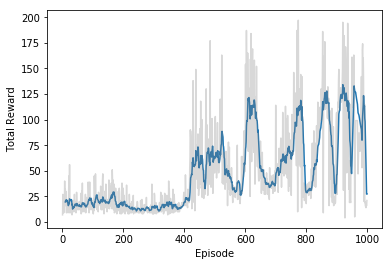

In [13]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.